In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import time
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# 1. Data Preprocessing

Memuat dan memproses Dataset CIFAR-10 untuk melakukan *Image Recognition* menggunakan CNN

Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Dataset sizes: Train=40000, Valid=10000, Test=10000
Classes in dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train label distribution: [3986 3986 4048 3984 4003 3975 4020 4023 3997 3978]
Validation label distribution: [1014 1014  952 1016  997 1025  980  977 1003 1022]
Test label distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


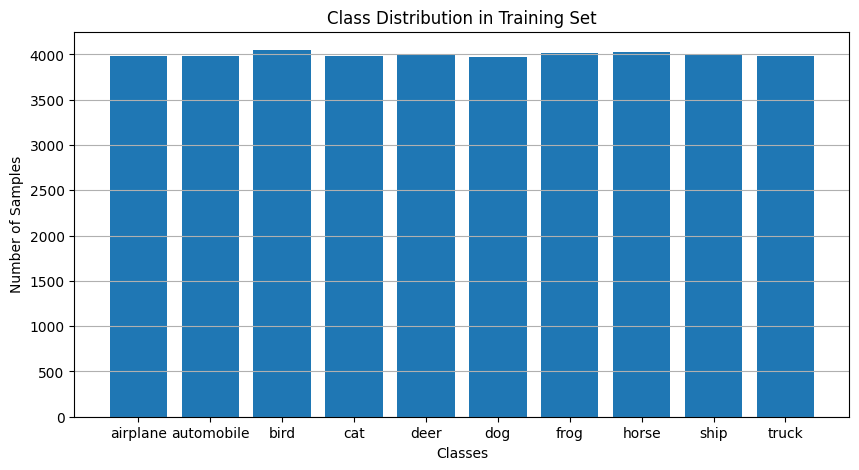


Sample data:


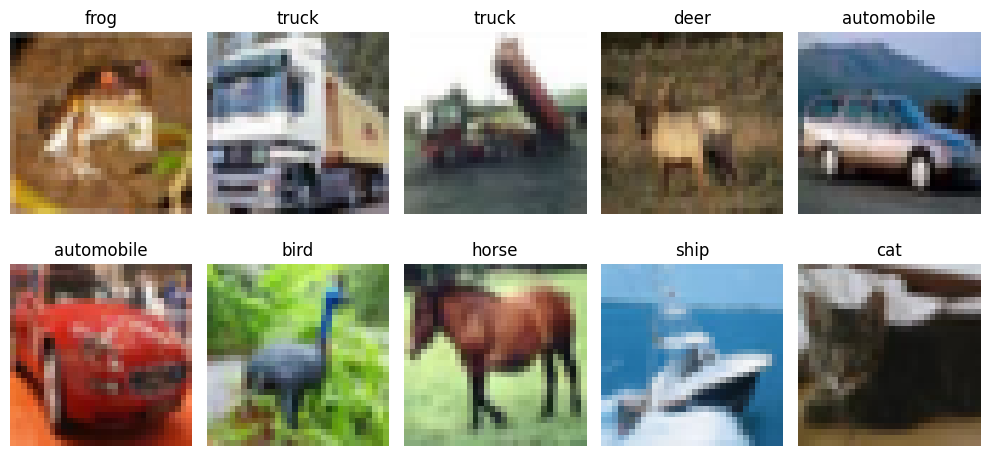

Image dimensions: Height=32, Width=32


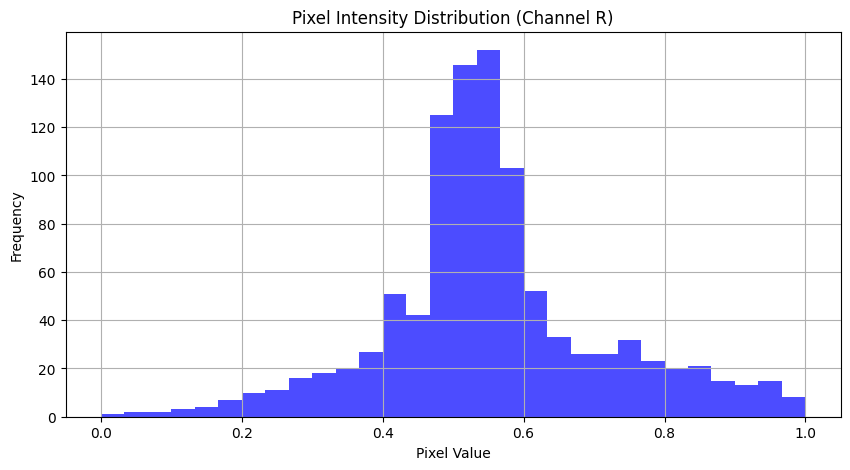

Sample image pixel statistics (Channel R):
Mean: 0.55
Median: 0.54
Max: 1.0


In [2]:
from data_preprocessing import load_cifar10_data

# Load CIFAR-10 dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()

# Print dataset sizes and class distribution
print(f"Dataset sizes: Train={len(x_train)}, Valid={len(x_val)}, Test={len(x_test)}")
print(f"Classes in dataset: {class_names}")
print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Validation label distribution: {np.bincount(y_val)}")
print(f"Test label distribution: {np.bincount(y_test)}")

# Visualisasi distribusi kelas dalam dataset pelatihan
plt.figure(figsize=(10, 5))
train_class_counts = np.bincount(y_train)
plt.bar(class_names, train_class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

# Menampilkan beberapa contoh gambar dari dataset
print("\nSample data:")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualisasi dimensi citra gambar
image_heights = [img.shape[0] for img in x_train]
image_widths = [img.shape[1] for img in x_train]
print(f"Image dimensions: Height={image_heights[0]}, Width={image_widths[0]}")

# Visualisasi distribusi pixel citra gambar
sample_image = x_train[0]
pixel_values = sample_image[:, :, 0].flatten()  # Choose one channel (e.g., R in RGB)
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=30, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution (Channel R)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display mean, median, and max values for pixel intensities
print(f"Sample image pixel statistics (Channel R):")
print(f"Mean: {np.mean(pixel_values):.2f}")
print(f"Median: {np.median(pixel_values):.2f}")
print(f"Max: {np.max(pixel_values)}")


# 2 Model CNN

Pada bagian ini, kita akan membuat serta melatih model CNN untuk melakukan klasifikasi gambar.

In [6]:
import config

print("CNN Model Parameters from config.py:")
print(f"- Number of convolutional layers: {config.NUM_CONV_LAYERS}")
print(f"- Base number of filters: {config.BASE_FILTERS}")
print(f"- Kernel size: {config.KERNEL_SIZE}")
print(f"- Pool size: {config.POOL_SIZE}")
print(f"- Dense layer units: {config.DENSE_UNITS}")
print(f"- Number of dense layers: {config.NUM_DENSE_LAYERS}")
print(f"- Dropout rate: {config.DROPOUT_RATE}")
print(f"- L2 regularization: {config.L2_REG}")
print(f"- Learning rate: {config.LEARNING_RATE}")

CNN Model Parameters from config.py:
- Number of convolutional layers: 3
- Base number of filters: 32
- Kernel size: (3, 3)
- Pool size: (2, 2)
- Dense layer units: 128
- Number of dense layers: 2
- Dropout rate: 0.3
- L2 regularization: 0.001
- Learning rate: 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

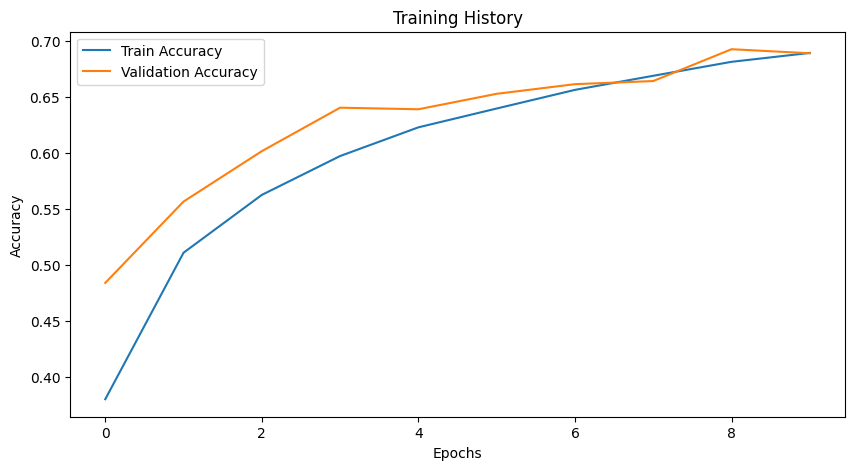

Test Loss: 1.1246
Test Accuracy: 0.6822
Test F1 Score: 0.6785


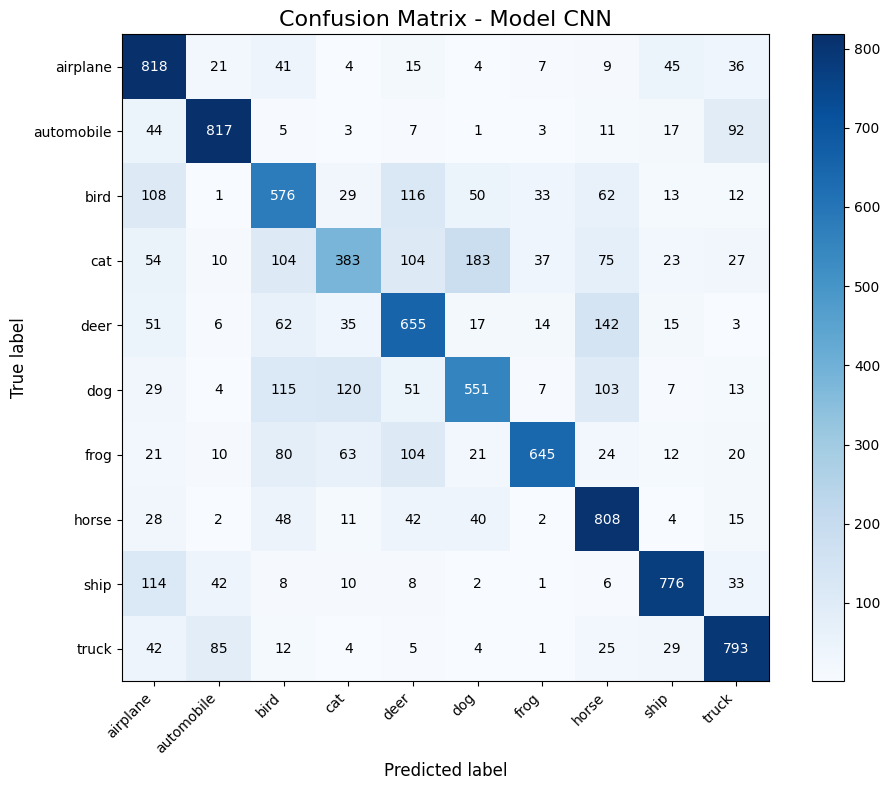


Classification Report:
              precision    recall  f1-score   support

    airplane       0.62      0.82      0.71      1000
  automobile       0.82      0.82      0.82      1000
        bird       0.55      0.58      0.56      1000
         cat       0.58      0.38      0.46      1000
        deer       0.59      0.66      0.62      1000
         dog       0.63      0.55      0.59      1000
        frog       0.86      0.65      0.74      1000
       horse       0.64      0.81      0.71      1000
        ship       0.82      0.78      0.80      1000
       truck       0.76      0.79      0.78      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [7]:
from model import build_cnn_model
from train import train_and_evaluate_cnn_model, plot_confusion_matrix
from sklearn.metrics import classification_report

# Dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalisasi data
train_images, test_images = train_images / 255.0, test_images / 255.0

# Split validasi
valid_images = train_images[-5000:]
valid_labels = train_labels[-5000:]
train_images = train_images[:-5000]
train_labels = train_labels[:-5000]

# Buat dataset TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Buat model CNN
model_cnn = build_cnn_model()

# Latih model
model_cnn, history, preds_cnn, labels_cnn, metrics_cnn = train_and_evaluate_cnn_model(
    model=model_cnn,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    test_dataset=test_dataset,
    class_names=class_names,
    epochs=10,
    patience=5
)

# Plot kurva training
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Tampilkan metrik evaluasi
print(f"Test Loss: {metrics_cnn['test_loss']:.4f}")
print(f"Test Accuracy: {metrics_cnn['test_accuracy']:.4f}")
print(f"Test F1 Score: {metrics_cnn['test_f1']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(preds_cnn, labels_cnn, class_names)

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(labels_cnn, np.argmax(preds_cnn, axis=1), target_names=class_names))


# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer konvolusi
2. Banyak filter per layer konvolusi
3. Ukuran filter per layer konvolusi
4. Jenis pooling layer